## Preprocessing Functions

In [ ]:
!pip install powerlaw
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.5 MB/s eta 0:00:00


In [ ]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [ ]:
"""
acf
This code from  ICascha/QuantGANs-replication
"""

import numpy as np
from sklearn.preprocessing import StandardScaler


def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): number of windows
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    """
    Computes autocorrelation for every lag from 1 to k inclusive
    """

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):

    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))

    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [ ]:
"""
gaussianize
Utility code from Greg Ver Steeg.
Transform data so that it is approximately normally distributed
"""

from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------

    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert',
                 tol: float = 1e-5,
                 max_iter: int = 100,
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose

    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)

        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest, pearsonr
from math import floor, ceil
import powerlaw as powerlaw
from arch import arch_model

## Baseline Model

[*********************100%***********************]  1 of 1 completed

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9239.85
Distribution:                  Normal   AIC:                          -18473.7
Method:            Maximum Likelihood   BIC:                          -18455.9
                                        No. Observations:                 2766
Date:                Sat, Apr 05 2025   Df Residuals:                     2766
Time:                        17:10:01   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1127e-06  3.795e-09    556.639      0.000 [2.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


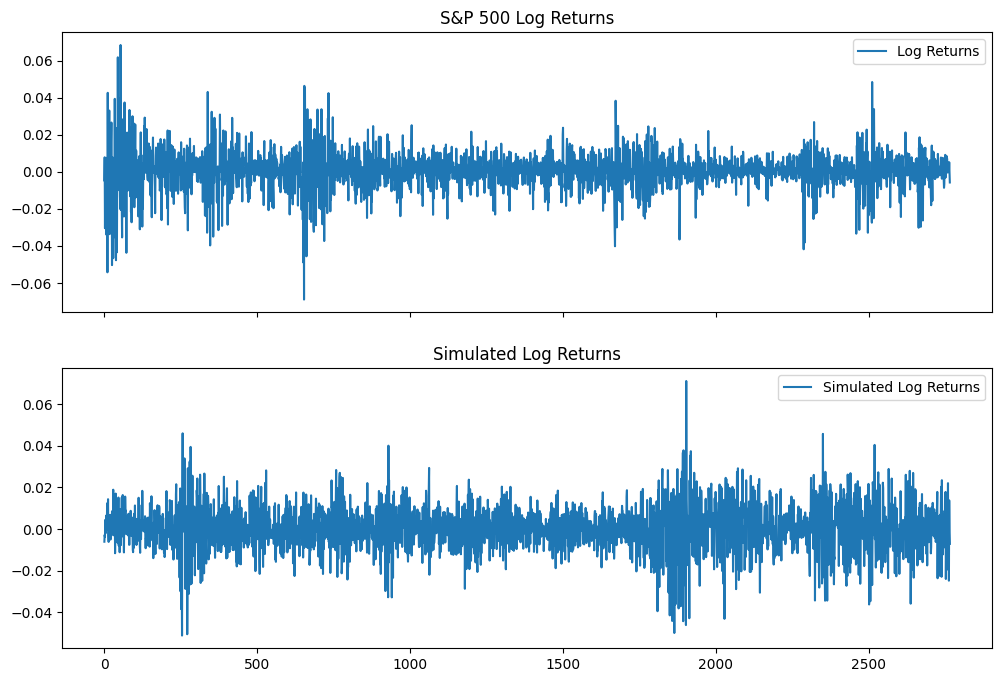

In [ ]:
# # 1. Download historical S&P 500 data (using SPY ETF as proxy)

data = yf.download("^GSPC", start="2009-01-01", end="2019-12-31")
df = data['Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)


# # Plot historical returns

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(log_returns, label='Log Returns')
axes[0].set_title('S&P 500 Log Returns')
axes[0].legend()


# 3. Fit an GARCH(1,1) model to the returns
#   [omega, alpha, beta]

# model = arch_model(log_returns, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='normal')
model = arch_model(log_returns, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
res = model.fit(update_freq=50, disp='off')
print(res.summary())



# 4. Simulate one series of synthetic data using the fitted model parameters
T = len(log_returns)  # number of observations to simulate
simulated = model.simulate(res.params, T)
simulated_series = simulated['data']


axes[1].plot(simulated_series, label='Simulated Log Returns')
axes[1].set_title('Simulated Log Returns')
axes[1].legend()

In [ ]:
simulated_series

,data
0,-0.006132
1,-0.002858
2,-0.003821
3,0.004372
4,-0.000791
...,...
2761,-0.000296
2762,-0.024863
2763,0.013746
2764,-0.001556


## Stylized Facts

In [ ]:
# Proceed to simulate ~400 time series, store them in y

T = len(log_returns)  # number of observations to simulate
y = []
for i in range(400):
    simulated = model.simulate(res.params, T)
    y.append(simulated['data'])
y = np.array(y)
y.shape

(400, 2766)

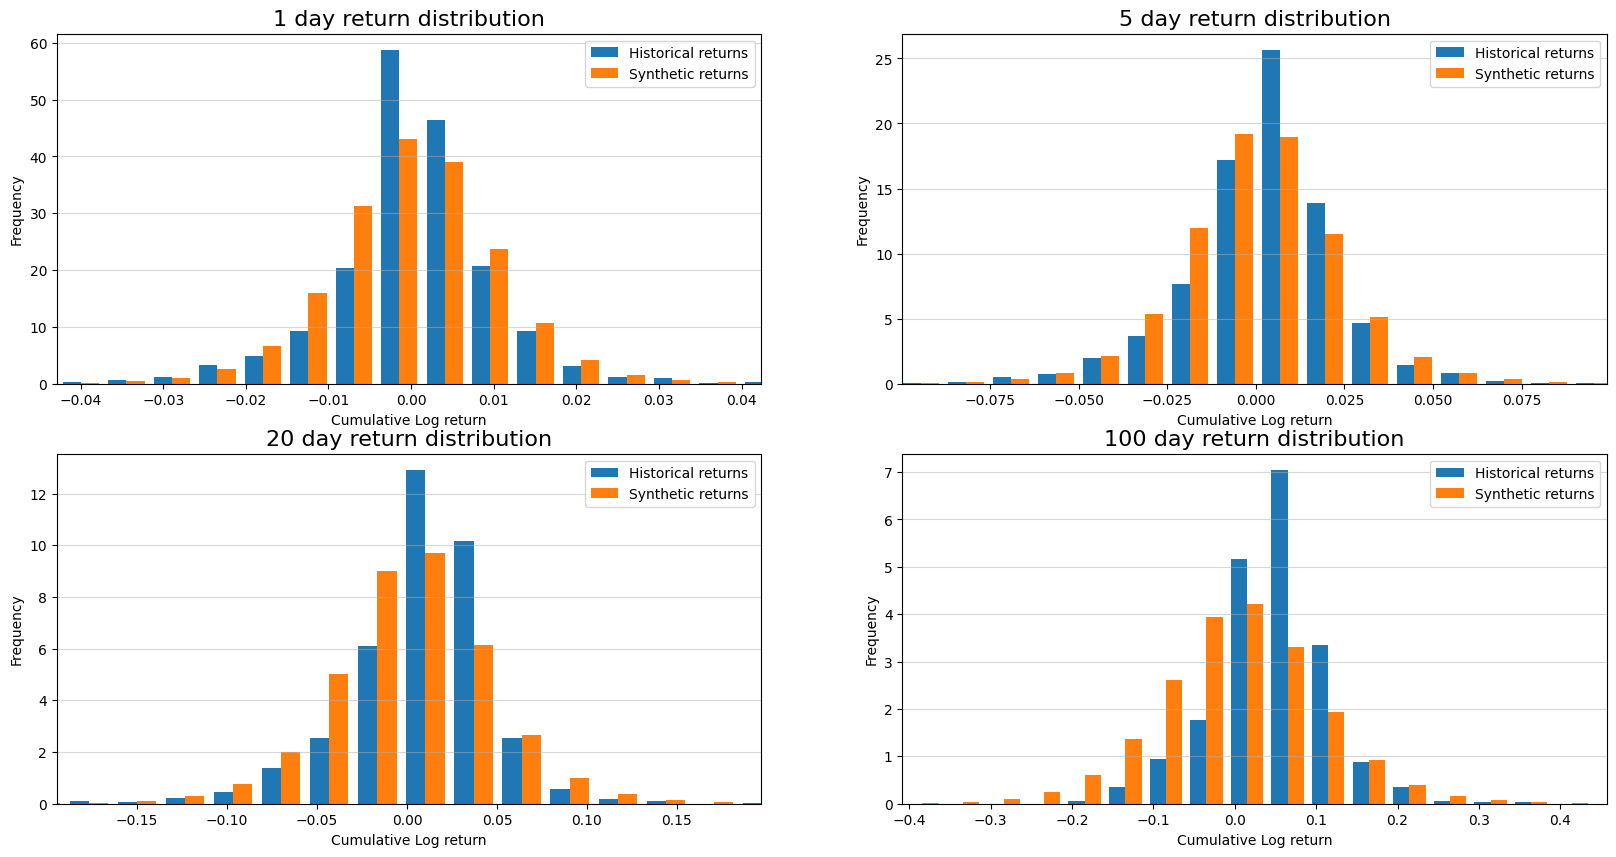

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative Log return')
    axs[row,col].set_ylabel('Frequency')

    axs[row,col].legend(['Historical returns', 'Synthetic returns'])

In [ ]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)
    # print(EMDscores[i])

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
df_EMD

,Earth Mover Distance
window size,
1,0.001338
5,0.003329
20,0.012051
100,0.051257


In [ ]:
df_acf = pd.DataFrame(columns=['2 Day Volatility Score', '5 Day Volatility Score', '20 Day Volatility Score',
                               '100 Day Volatility Score', 'Vanilla ACF Score', 'Squared ACF Score',
                               'Absolute ACF Score', 'Leverage Effect Score', 'Volatility Persistence Score'])

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

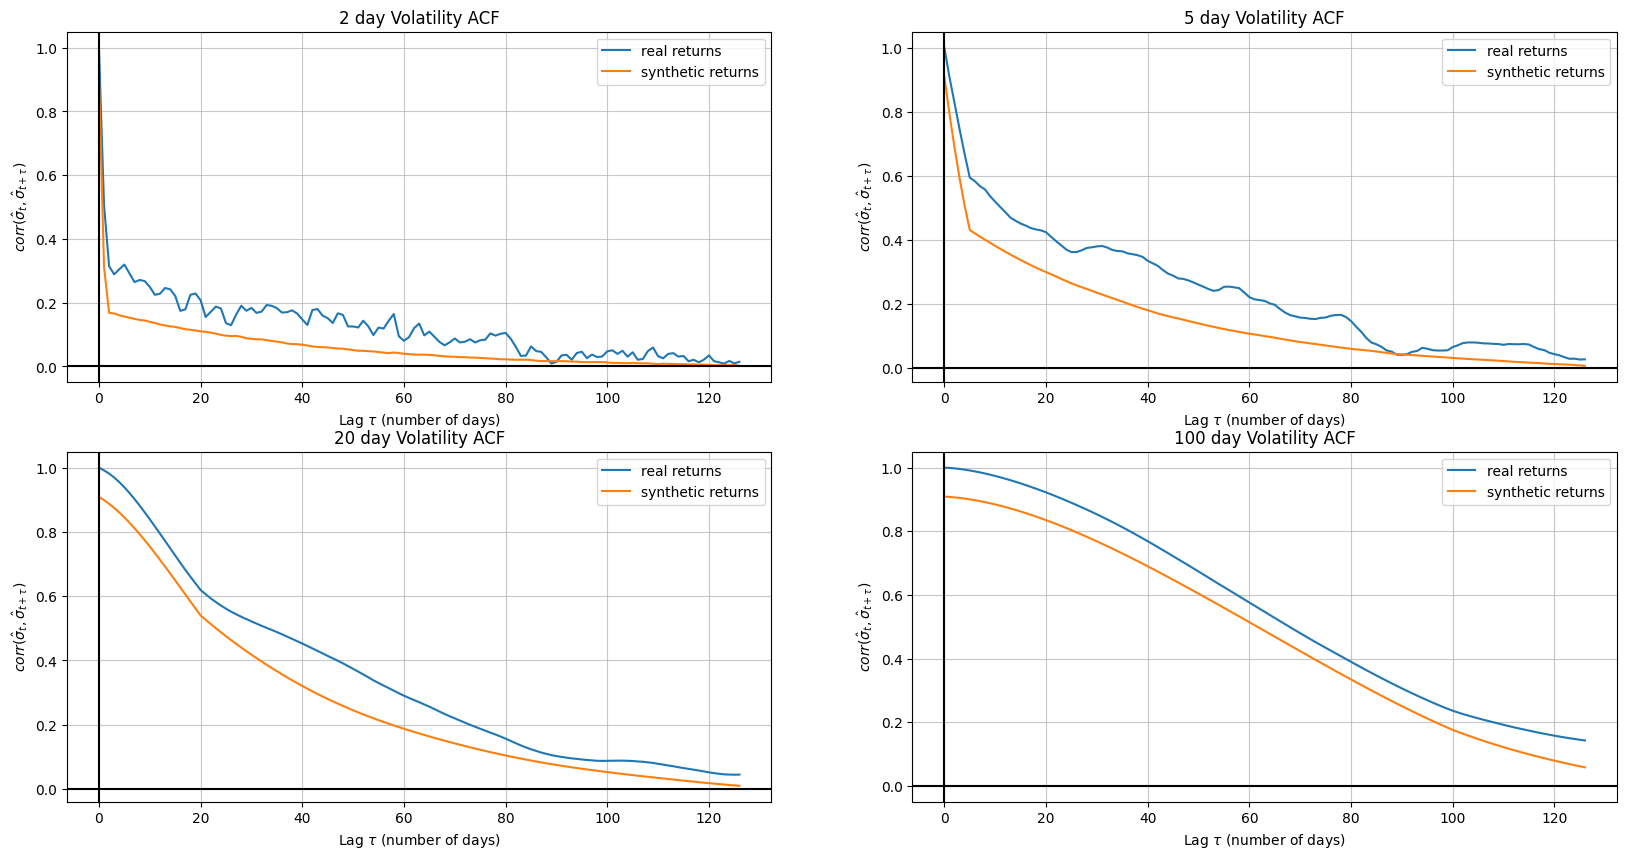

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

T = 127
vol_scores = []

# 1 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 2).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf,1)
real_acf = acf(rolling_window(log_returns, 2).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,0].grid(alpha=0.7)
axs[0,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('2 day Volatility ACF')


# 5 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 5).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 5).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,1].grid(alpha=0.7)
axs[0,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,1].set_title('5 day Volatility ACF')



# 20 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 20).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 20).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,0].grid(alpha=0.7)
axs[1,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,0].set_title('20 day Volatility ACF')


# 100 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 100).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 100).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,1].grid(alpha=0.7)
axs[1,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,1].set_title('100 day Volatility ACF')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

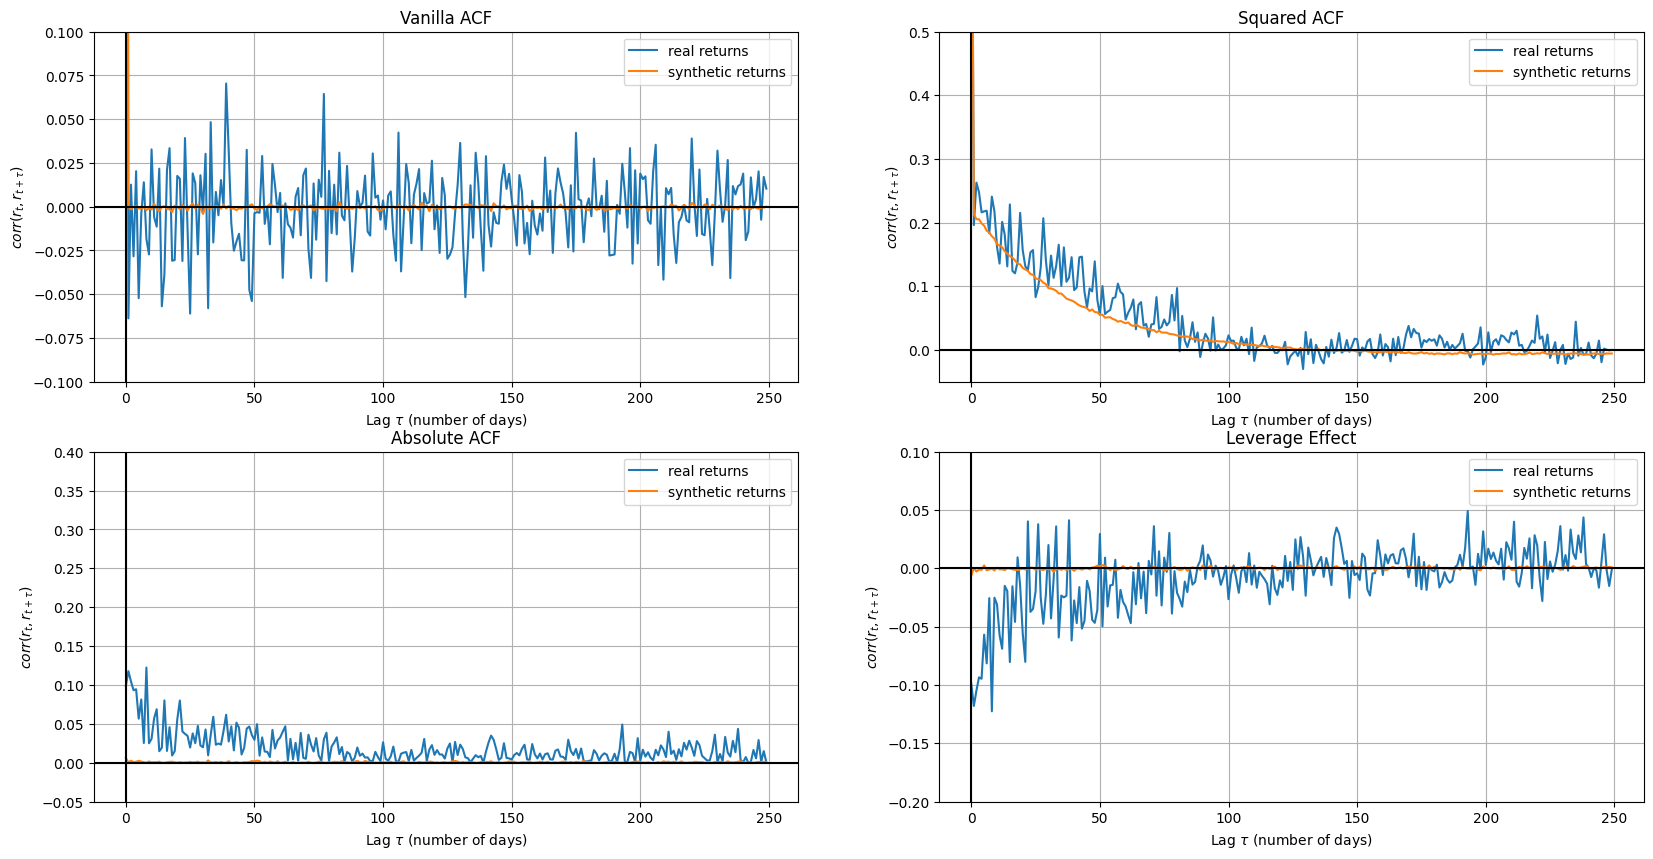

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

lags = 250
acf_scores = []

# Vanilla ACF
real_acf = acf(log_returns, lags)
fake_acf = acf(y.T, lags).mean(axis=1, keepdims=True)
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Vanilla ACF')


# Squared  ACF
real_acf = acf(log_returns**2, lags)
fake_acf = acf(y.T**2, lags).mean(axis=1, keepdims=True)
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].set_title('Squared ACF')

# Absolute  ACF
real_acf = abs(acf(log_returns, lags, le=True))
fake_acf = abs(acf(y.T, lags, le=True).mean(axis=1, keepdims=True))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute ACF')


# Leverage Effect
real_acf = acf(log_returns, lags, le=True)
fake_acf = acf(y.T, lags, le=True).mean(axis=1, keepdims=True)
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage Effect')


for ax in axs.flat:
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Real Data Parameters:
omega: 2.435204357343744e-06, alpha: 0.10116525895820278, beta: 0.878793080389131, alpha + beta: 0.9799583393473337

Synthetic Data Parameters:
omega: 2.3774551603526326e-06, alpha: 0.09999995147331393, beta: 0.8799987456931374, alpha + beta: 0.9799986971664514



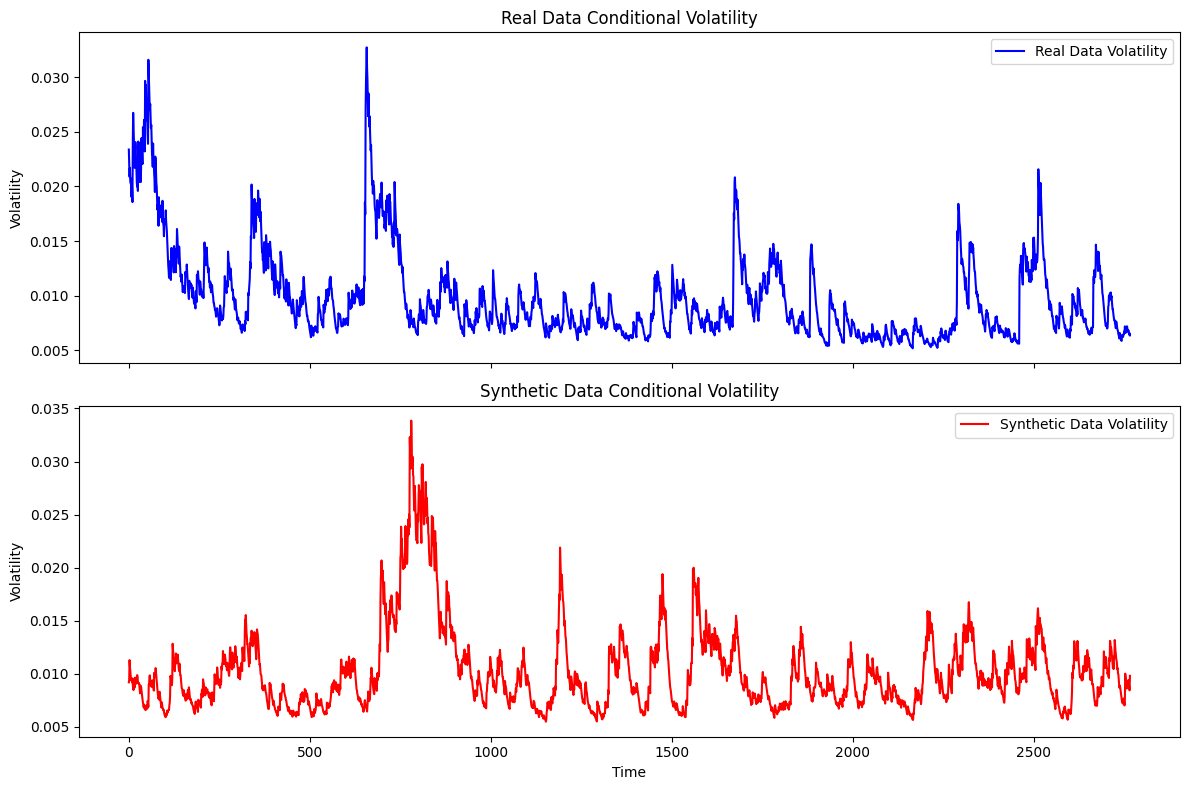

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'real_returns' and 'synthetic_returns' are your datasets as pandas Series

# Fit GARCH(1,1) model to real data
garch_real = arch_model(log_returns, vol='Garch', p=1, q=1)
res_real = garch_real.fit(disp='off')
omega_real, alpha_real, beta_real = res_real.params[['omega', 'alpha[1]', 'beta[1]']]

# Fit GARCH(1,1) model to synthetic data
garch_synth = arch_model(y[4], vol='Garch', p=1, q=1)
res_synth = garch_synth.fit(disp='off')
omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]

# Print the estimated parameters
print("Real Data Parameters:")
print(f"omega: {omega_real}, alpha: {alpha_real}, beta: {beta_real}, alpha + beta: {alpha_real + beta_real}\n")

print("Synthetic Data Parameters:")
print(f"omega: {omega_synth}, alpha: {alpha_synth}, beta: {beta_synth}, alpha + beta: {alpha_synth + beta_synth}\n")

# Plotting the conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Real data volatility
axes[0].plot(res_real.conditional_volatility, color='blue', label='Real Data Volatility')
axes[0].set_title('Real Data Conditional Volatility')
axes[0].set_ylabel('Volatility')
axes[0].legend()

# Synthetic data volatility
axes[1].plot(res_synth.conditional_volatility, color='red', label='Synthetic Data Volatility')
axes[1].set_title('Synthetic Data Conditional Volatility')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Volatility')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# We call alpha + beta the volatility persistence score
alphabeta_sum = 0
for i in range(len(y)):
  garch_synth = arch_model(y[i], vol='Garch', p=1, q=1)
  res_synth = garch_synth.fit(disp='off')
  omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]
  alphabeta_sum += alpha_synth + beta_synth

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.47e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.803e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarni

In [ ]:
# # Average volatility persistence score for synthetic data
print(alphabeta_sum/len(y))

0.979863697563334


In [ ]:
all_scores = []
all_scores.extend(vol_scores)
all_scores.extend(acf_scores)
all_scores.append(alphabeta_sum/len(y))
df_acf.loc[len(df_acf)] = all_scores
df_acf

,2 Day Volatility Score,5 Day Volatility Score,20 Day Volatility Score,100 Day Volatility Score,Vanilla ACF Score,Squared ACF Score,Absolute ACF Score,Leverage Effect Score,Volatility Persistence Score
0,0.846446,1.152004,0.936062,0.821481,0.358265,0.421088,0.44448,0.450669,0.979864


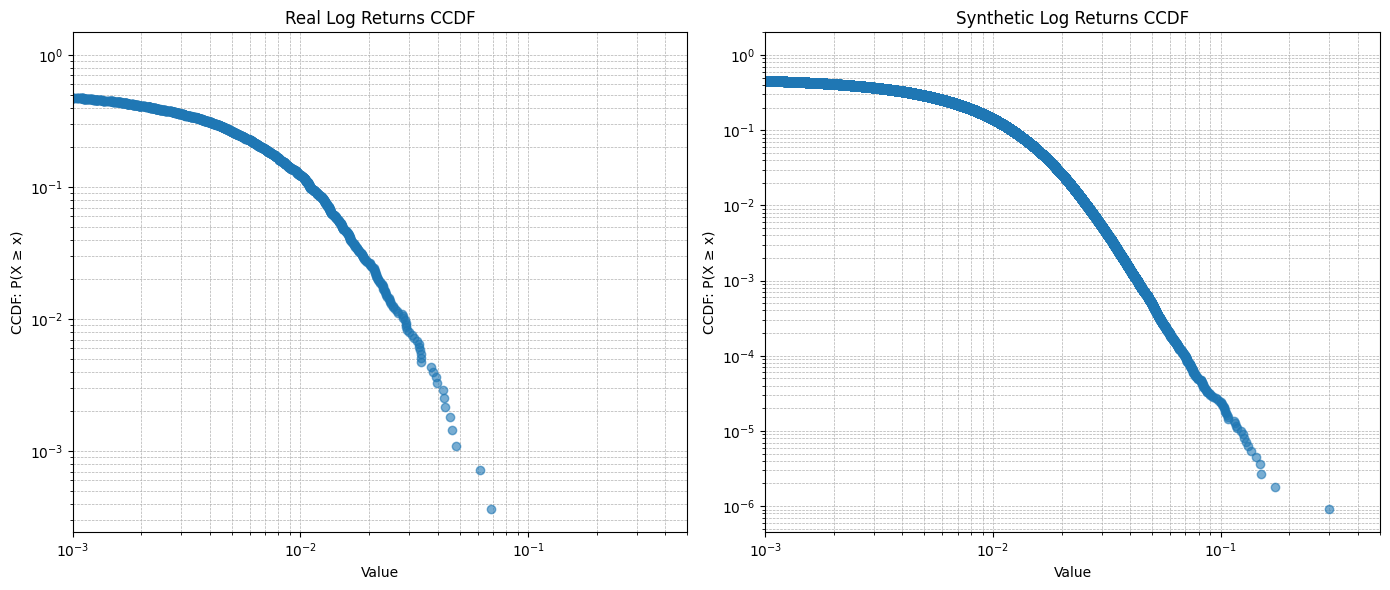

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ccdf(data, ax, title):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of the data on a log-log scale.

    Parameters:
        data (array-like): The data to be plotted.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        title (str): Title of the subplot.
    """
    # Sort the data in descending order
    sorted_data = np.sort(data)[::-1]
    n = len(sorted_data)
    # Compute the CCDF: rank / total number of points
    ccdf = np.arange(1, n+1) / n

    # Plot using log-log scale
    ax.loglog(sorted_data, ccdf, marker='o', linestyle='none', alpha=0.6)
    ax.set_xlim(0.001, 0.5)
    ax.set_xlabel("Value")
    ax.set_ylabel("CCDF: P(X ≥ x)")
    ax.set_title(title)
    ax.grid(True, which='both',  ls='--', lw=0.5)

# Assume real_log_returns and synthetic_log_returns are your datasets.
# If synthetic_log_returns is 2D (e.g., 80 x 2500), we flatten it.
real_data = log_returns.flatten() if log_returns.ndim > 1 else log_returns
synthetic_data = y.flatten() if y.ndim > 1 else y

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ccdf(real_data, axes[0], "Real Log Returns CCDF")
plot_ccdf(synthetic_data, axes[1], "Synthetic Log Returns CCDF")

plt.tight_layout()
plt.show()

In [ ]:
import powerlaw
# Real data
fit = powerlaw.Fit(log_returns.flatten(), xmin=0.01)
print(fit.power_law.alpha)

# Synthetic/fake data
fit = powerlaw.Fit(y.flatten(), xmin=0.01)
print(fit.power_law.alpha)

3.302494130490744
3.3976141296615365


Values less than or equal to 0 in data. Throwing out 0 or negative values


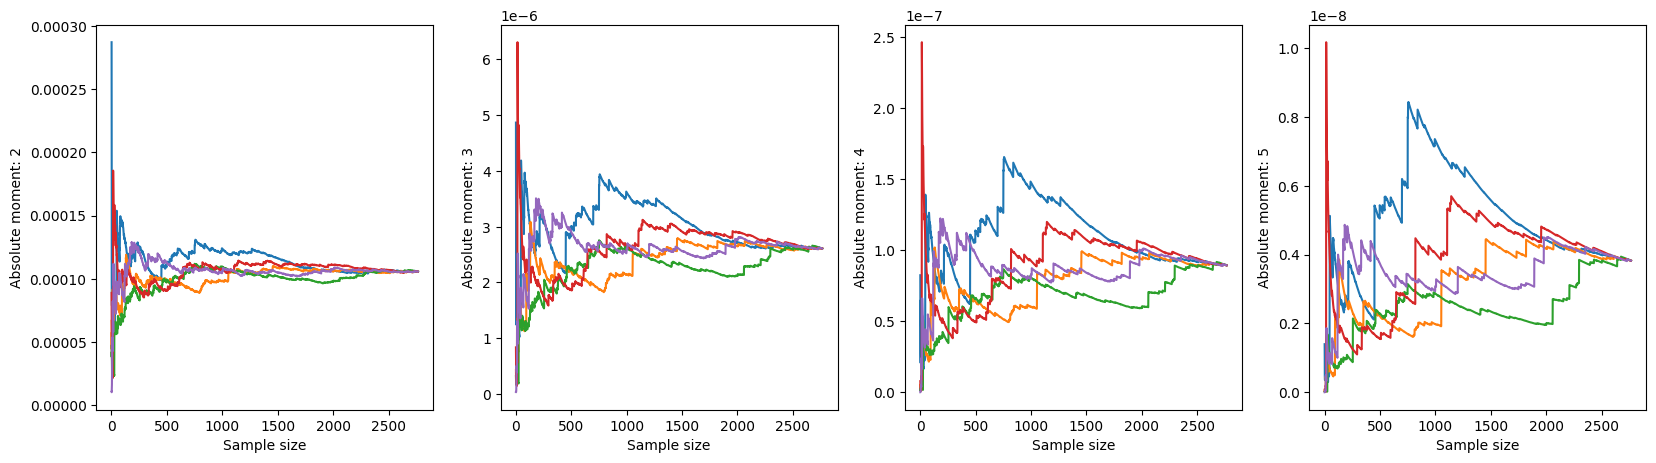

In [ ]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

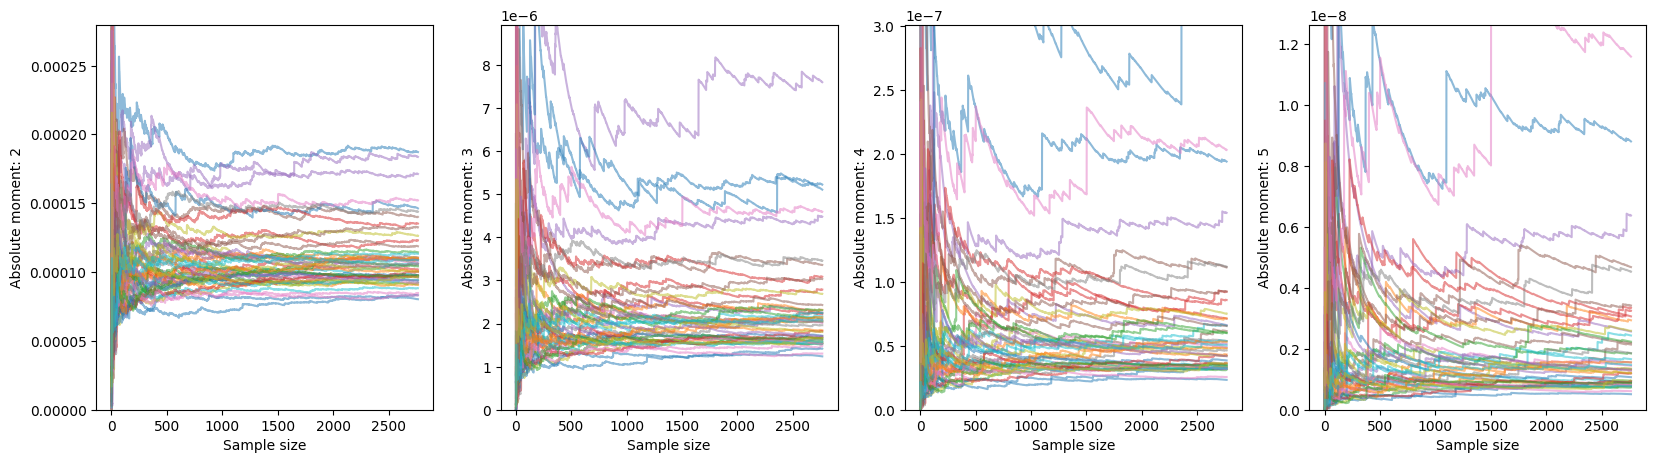

In [ ]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
# x_range = range(1, 251)
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    # ax[j].set_xlim(0, 250)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))